### MARBL - SCOPE (Standard Carbon and Ocean Plankton Ecosystem)
#### compare to copepod climatology


In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
from cartopy.util import add_cyclic_point
from IPython.display import Image
import utils
import pop_tools

### Define latest year and get the CESM data

In [2]:
start_yr = 60
num_years = 1
endyr = start_yr + num_years 
case = 'g.e22a06.G1850ECOIAF_JRA_PHYS_DEV.TL319_g17.scope_v1'
user = 'kristenk'

In [3]:
files = []
for year in range(start_yr,endyr):
    yr4="{:04d}".format(year)
    print('doing simulation year', year, '!')
    for month in range(1, 13):
    
        mo2="{:02d}".format(month)
        files.extend(sorted(glob(f'/glade/scratch/{user}/archive/{case}/ocn/hist/{case}.pop.h.{yr4}-{mo2}.nc')))
        #files.extend(sorted(glob(f'/glade/scratch/{user}/{case}/run/{case}.pop.h.{yr4}-{mo2}.nc')))

doing simulation year 60 !


In [4]:
cesm_mon_ds=xr.open_mfdataset(files,decode_times=False,decode_coords=False, concat_dim='time')

### Keep only the variables we need

In [5]:
variables = ['mesozooC'] 
coords = {'x':'TLONG','y':'TLAT'}

In [6]:
keepthese=['z_t','z_t_150m','time_bound','TAREA','REGION_MASK'] + variables
keep_vars = keepthese +list(coords.values())+['dz','KMT']
cesm_mon_ds = cesm_mon_ds.drop([v for v in cesm_mon_ds.variables if v not in keep_vars])

In [7]:
cesm_ann_ds=cesm_mon_ds.mean(dim='time')

In [8]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lons=ds_grid.TLONG
lats=ds_grid.TLAT
area=ds_grid.TAREA
depths=ds_grid.z_t * 0.01
area_m=area * 1.e-4
dz_m=ds_grid.dz * 0.01

### First, show original COPEPOD comparison

In [9]:
file = '/glade/u/home/kristenk/work/copepod-biomass/data/POP_gx1v7/copepod-2012__cmass-m00-qtr.zarr'
ds_copepod = xr.open_zarr(file)
ds_copepod.copepod_C

<xarray.DataArray 'copepod_C' (lat: 384, lon: 320)>
dask.array<xarray-copepod_C, shape=(384, 320), dtype=float64, chunksize=(192, 160), chunktype=numpy.ndarray>
Dimensions without coordinates: lat, lon
Attributes:
    long_name:  Total Carbon Mass
    units:      mg-C m$^{-3}$

In [10]:
### convert from mgC/m3 to mmol/m3 to be in the same units as CESM
ds_copepod['copepod_C'] = ds_copepod.copepod_C/12.011

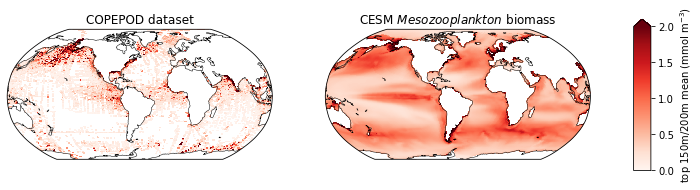

In [11]:
fig = plt.figure(figsize=(12,3))

ax = fig.add_subplot(1,2,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD dataset', fontsize=12)
tmp = ds_copepod.copepod_C
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
ax = fig.add_subplot(1,2,2, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('CESM ${\it Mesozooplankton}$ biomass', fontsize=12)
tmp = cesm_ann_ds.mesozooC.mean(dim='z_t_150m')
lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=2,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='top 150m/200m mean (mmol m$^{-3}$)')

### compare to spatially interpolated COPEPOD climatology

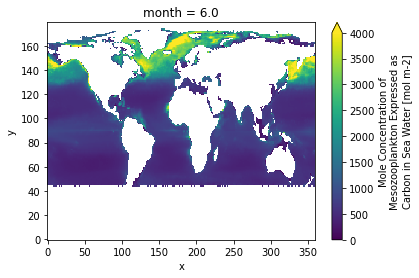

In [12]:
file = '/glade/u/home/kristenk/work/copepod-biomass/obsglmm_zmeso_vint_200m_monthly_climatology.nc'
ds_copepod_clim = xr.open_dataset(file)

ds_copepod_clim.zmeso200.isel(month=5).plot(vmin=0,vmax=4000) #['copepod_C']=ds_copepod.copepod_C/12.011

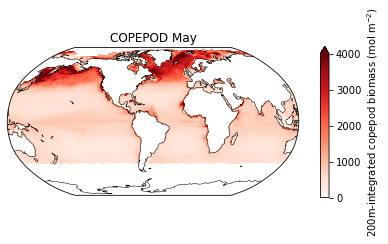

In [13]:
fig = plt.figure(figsize=(6,3))

ax = fig.add_subplot(1,1,1, projection=ccrs.Robinson(central_longitude=305.0))
ax.set_title('COPEPOD May', fontsize=12)
pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=5), cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
ax.coastlines('110m',linewidth=0.5)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='200m-integrated copepod biomass (mol m$^{-2}$)')

In [14]:
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

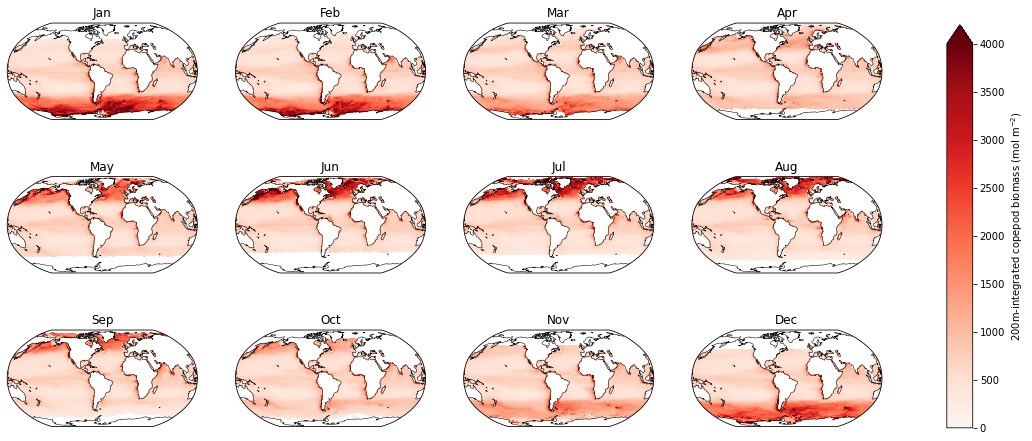

In [15]:
fig = plt.figure(figsize=(18,8))

for row in np.arange(1,4):
    
    plot = row*4 - 3
    ts = plot - 1
    ax = fig.add_subplot(3,4,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*4 - 2
    ts = plot - 1
    ax = fig.add_subplot(3,4,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*4 - 1
    ts = plot - 1
    ax = fig.add_subplot(3,4,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*4
    ts = plot - 1
    ax = fig.add_subplot(3,4,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='200m-integrated copepod biomass (mol m$^{-2}$)')

In [16]:
### depth integrate and convert model to mol/m2
cesm_mon_ds['mesozooC_zint'] = ((cesm_mon_ds.mesozooC) * 10.).sum(dim='z_t_150m') 
cesm_mon_ds['mesozooC_zint'].attrs['units'] = 'mmol/m2'

In [17]:
### convert from mmol/m2 to mol/m2
cesm_mon_ds['mesozooC_zint'] = cesm_mon_ds['mesozooC_zint'] * 0.001
cesm_mon_ds['mesozooC_zint'].attrs['units'] = 'mol/m2'

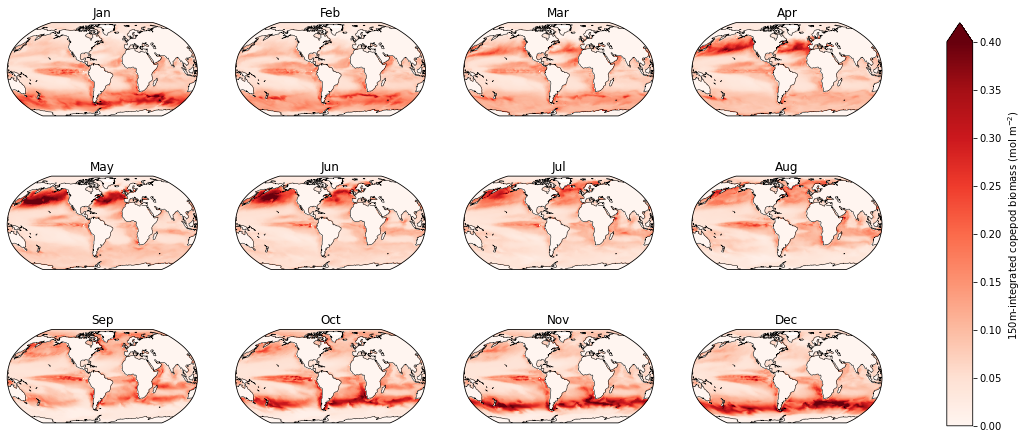

In [18]:
fig = plt.figure(figsize=(18,8))

for row in np.arange(1,4):
    
    plot = row*4 - 3
    ts = plot - 1
    ax = fig.add_subplot(3,4,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(time=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*4 - 2
    ts = plot - 1
    ax = fig.add_subplot(3,4,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(time=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*4 - 1
    ts = plot - 1
    ax = fig.add_subplot(3,4,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(time=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*4
    ts = plot - 1
    ax = fig.add_subplot(3,4,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(time=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=0.4,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='150m-integrated copepod biomass (mol m$^{-2}$)')

#### CESM depth integrated mesozoo biomass is 10,000-fold lower than in the climatology !!

## Let's assume the COPEPOD climatology is actually in mg C/m2 (which corresponds to the units in the original COPEPOD database of mg/m3)

In [19]:
### convert CESM data from mol/m2 to mg/m2
cesm_mon_ds['mesozooC_zint'] = cesm_mon_ds['mesozooC_zint'] * 1000. * 12.011
cesm_mon_ds['mesozooC_zint'].attrs['units'] = 'mgC/m2'

### Plot 12 months, COPEPOD climatology and CESM, side by side
#### obs on left, model on right

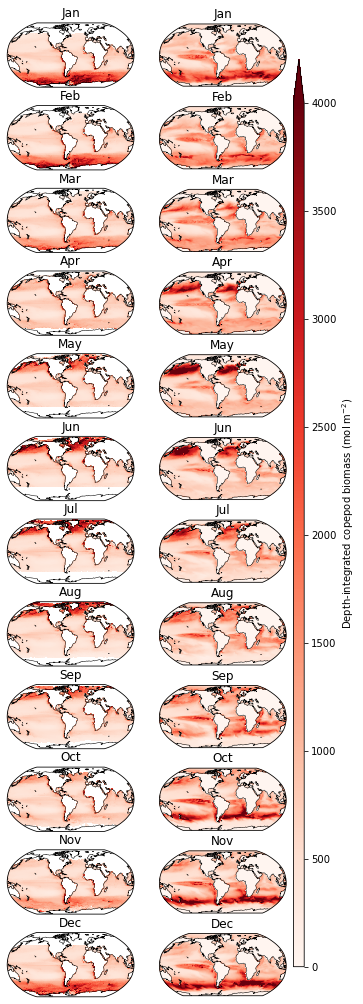

In [20]:
fig = plt.figure(figsize=(5,18))

for row in np.arange(1,13):
    
    ts=row-1
    
    plot = row*2 - 1
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    pc=ax.pcolormesh(ds_copepod_clim.Lon, ds_copepod_clim.Lat, ds_copepod_clim.zmeso200.isel(month=ts), cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)
    
    plot = row*2
    ax = fig.add_subplot(12,2,plot, projection=ccrs.Robinson(central_longitude=305.0))
    ax.set_title(months[ts], fontsize=12)
    tmp = cesm_mon_ds.mesozooC_zint.isel(time=ts)
    lon, lat, field = utils.adjust_pop_grid(lons, lats,  tmp)
    pc=ax.pcolormesh(lon, lat, field, cmap='Reds',vmin=0,vmax=4000,transform=ccrs.PlateCarree())
    ax.coastlines('110m',linewidth=0.5)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])
fig.colorbar(pc, cax=cbar_ax,extend='max', label='Depth-integrated copepod biomass (mol m$^{-2}$)');

### If I assume that the COPEPOD climatology is actually in mgC/m2, then the model compares much better. There are positive model biases around the equatorial Pacific and in the subantarctic Southern Ocean.. and negative model biases in the Arctic and Antarctic sea ice zones